<center><h1>In the name of Allah</h1></center>

Name: Amirhossein Akbari

Student Number: 400104737

In this notebook, you will explore adversarial attacks and training methods in deep learning. First, you will train a simple model, ResNet18, on the CIFAR-10 dataset. Next, you will learn about two different adversarial attacks: FGSM (Fast Gradient Sign Method) and PGD (Projected Gradient Descent). To enhance your understanding, you will implement the PGD attack from scratch, while the FGSM attack will be implemented using a library. After this, you will use the FGSM attack to generate adversarial examples and then perform adversarial training on the model using the CIFAR-10 dataset. Finally, you will compare the performance and robustness of the adversarially trained model with the original model.

Good luck!

## outline
- Train Resnet on CIFAR10
- FGSM Attack using torchattacks
- PGD Attack from scratch
- Visualization
- Adversarial Training


In [ ]:
pip install torchattacks

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.autograd import Variable
from tqdm import tqdm
from torch.utils.data import DataLoader
import torchattacks
import matplotlib.pyplot as plt

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


## Train Resnet on CIFAR10 (15 pts)

In [ ]:
# Prepare Cifar10 data
batch_size = 128
transform = transforms.Compose([transforms.ToTensor(),])

##############################################################################
# Prepare training and test datasets and dataloaders                         #
##############################################################################
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
################################ End #########################################

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# model architecture
class resnet(nn.Module):
  def __init__(self, num_cls):
    super().__init__()
    self.conv = nn.Sequential(*list(resnet18(weights=None).children())[:-2])
    self.fc = nn.Linear(512, num_cls)

  def forward(self, x):
    x = self.conv(x)
    x = torch.flatten(x, start_dim=1)
    logits = self.fc(x)
    return logits

##############################################################################
# Initialize model and move to device                                        #
##############################################################################
model = resnet(num_cls=10).to(device)

################################ End #########################################

In [ ]:
learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
epochs = 35

In [ ]:
##############################################################################
# Implement train loop and log training loss after each epoch                #
##############################################################################
def train_model(model, trainloader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(trainloader):.4f}')
    print('Finished Training')

################################ End #########################################

In [ ]:
##############################################################################
# Evaluate the trained model on test set and print test accuracy             #
##############################################################################
def test_model(model, testloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f}%')
################################ End #########################################

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_model(model, trainloader, criterion, optimizer, epochs)

test_model(model, testloader)

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [1/35], Loss: 1.3764
Epoch [2/35], Loss: 0.9900
Epoch [3/35], Loss: 0.8121
Epoch [4/35], Loss: 0.6818
Epoch [5/35], Loss: 0.5808
Epoch [6/35], Loss: 0.4892
Epoch [7/35], Loss: 0.4040
Epoch [8/35], Loss: 0.3344
Epoch [9/35], Loss: 0.2702
Epoch [10/35], Loss: 0.2230
Epoch [11/35], Loss: 0.1877
Epoch [12/35], Loss: 0.1540
Epoch [13/35], Loss: 0.1257
Epoch [14/35], Loss: 0.1216
Epoch [15/35], Loss: 0.1105
Epoch [16/35], Loss: 0.0890
Epoch [17/35], Loss: 0.0974
Epoch [18/35], Loss: 0.0728
Epoch [19/35], Loss: 0.0766
Epoch [20/35], Loss: 0.0726
Epoch [21/35], Loss: 0.0685
Epoch [22/35], Loss: 0.0721
Epoch [23/35], Loss: 0.0564
Epoch [24/35], Loss: 0.0588
Epoch [25/35], Loss: 0.0504
Epoch [26/35], Loss: 0.0593
Epoch [27/35], Loss: 0.0490
Epoch [28/35], Loss: 0.0561
Epoch [29/35], Loss: 0.0447
Epoch [30/35], Loss: 0.0490
Epoch [31/35], Loss: 0.0397
Epoch [32/35], Loss: 0.0463
Epoch [33/35], Loss: 0.0385
Epoch [34/35], Loss: 0.0451
Epoch [35/35], Loss: 0.0346
Finished Training
Accuracy of

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


In [ ]:
# Save model
model.eval()
model_name = "resnet18_cifar10_model_pretrained.pth"
model_PATH = f"{model_name}"
torch.save(model.state_dict(), model_PATH)

## FGSM Attack using torchattacks (10 pts)

In this section you should run FGSM attack using torchattacks library (https://adversarial-attacks-pytorch.readthedocs.io/en/latest/index.html).

Run the attack for $\epsilon \in \{\frac{1}{255}, \frac{4}{255}, \frac{8}{255},\}$ report the performance of the model on untargeted FGSM attack on the test data.

In [ ]:
def run_fgsm_attack(model, testloader, epsilon):
    model.eval()
    attack = torchattacks.FGSM(model, eps=epsilon)
    correct = 0
    total = 0
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        # Set requires_grad attribute of tensor
        images.requires_grad = True

        # Perform attack
        adv_images = attack(images, labels)

        # Evaluate adversarial examples
        outputs = model(adv_images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy of the model on the test images with FGSM attack (epsilon={epsilon}): {accuracy:.2f}%')
    return accuracy

In [ ]:
##############################################################################
# run untargeted FGSM attack for epsilon = 1/255 and report its accuracy     #
##############################################################################
epsilon_1_255 = 1/255
accuracy_1_255 = run_fgsm_attack(model, testloader, epsilon_1_255)
################################ End #########################################

Accuracy of the model on the test images with FGSM attack (epsilon=0.00392156862745098): 54.57%


In [ ]:
##############################################################################
# run untargeted FGSM attack for epsilon = 4/255 and report its accuracy     #
##############################################################################
epsilon_4_255 = 4/255
accuracy_4_255 = run_fgsm_attack(model, testloader, epsilon_4_255)
################################ End #########################################

Accuracy of the model on the test images with FGSM attack (epsilon=0.01568627450980392): 18.63%


In [ ]:
##############################################################################
# run untargeted FGSM attack for epsilon = 8/255 and report its accuracy     #
##############################################################################
epsilon_8_255 = 8/255
accuracy_8_255 = run_fgsm_attack(model, testloader, epsilon_8_255)
################################ End #########################################

Accuracy of the model on the test images with FGSM attack (epsilon=0.03137254901960784): 5.96%


## PGD Attack from scratch (30 pts)

In this section you should implement PGD attack from scratch.

In [ ]:
class LinfPGDAttack(object):

    def __init__(self, model, epsilon=8/255, k=2, alpha=2/255):
        self.model = model
        self.epsilon = epsilon
        self.steps = k
        self.alpha = alpha

    def __call__(self, image, label):
        image = image.to(device)
        label = label.to(device)

        out = self.model(image)
        _, pred = torch.max(out, 1)

        perturbed_image = image.clone().detach()
        perturbed_image = perturbed_image.to(device)

        if pred.item() == label.item():
            ##############################################################################
            # Implement a k step PGD attack of size alpha                                #
            # while always staying within epsilon distance from the initial point        #
            # Use cross entropy loss                                                     #
            ##############################################################################
            loss_fn = nn.CrossEntropyLoss()

            for _ in range(self.steps):
                perturbed_image.requires_grad = True
                outputs = self.model(perturbed_image)

                self.model.zero_grad()
                loss = loss_fn(outputs, label)
                loss.backward()

                adv_images = perturbed_image + self.alpha * perturbed_image.grad.sign()
                eta = torch.clamp(adv_images - image, min=-self.epsilon, max=self.epsilon)
                perturbed_image = torch.clamp(image + eta, min=0, max=1).detach()
            ################################ End #########################################

        return perturbed_image


In [ ]:
def run_pgd_attack(model, testloader, epsilon, k, alpha):
    model.eval()
    pgd_attack = LinfPGDAttack(model, epsilon=epsilon, k=k, alpha=alpha)
    correct = 0
    total = 0
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        perturbed_images = torch.zeros_like(images)
        for i in range(len(images)):
            perturbed_images[i] = pgd_attack(images[i].unsqueeze(0), labels[i].unsqueeze(0))

        outputs = model(perturbed_images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy of the model on the test images with PGD attack (epsilon={epsilon}, k={k}, alpha={alpha}): {accuracy:.2f}%')
    return accuracy

In [ ]:
##############################################################################
# Evaluate PGD attack on the trained model with k=2,4,8                      #
##############################################################################

k_list = [2,4,8]

##############################################################################

epsilon = 8/255
alpha = 2/255

for k in k_list:
    run_pgd_attack(model, testloader, epsilon, k, alpha)

################################ End #########################################

Accuracy of the model on the test images with PGD attack (epsilon=0.03137254901960784, k=2, alpha=0.00784313725490196): 14.55%
Accuracy of the model on the test images with PGD attack (epsilon=0.03137254901960784, k=4, alpha=0.00784313725490196): 1.89%
Accuracy of the model on the test images with PGD attack (epsilon=0.03137254901960784, k=8, alpha=0.00784313725490196): 0.64%


## Visualization (10 pts)

Implement a function to plot the original image, the perturbed imaged and their predicted labels by the model

In [ ]:
##############################################################################
# Implement the function described                                           #
##############################################################################
def plot_images(original, perturbed, original_label, perturbed_label, classes):
    original = original.cpu().numpy().transpose(1, 2, 0)
    perturbed = perturbed.cpu().numpy().transpose(1, 2, 0)

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(original)
    axs[0].set_title(f'Original Image\nLabel: {classes[original_label]}')
    axs[0].axis('off')

    axs[1].imshow(perturbed)
    axs[1].set_title(f'Perturbed Image\nLabel: {classes[perturbed_label]}')
    axs[1].axis('off')

    plt.show()
################################ End #########################################

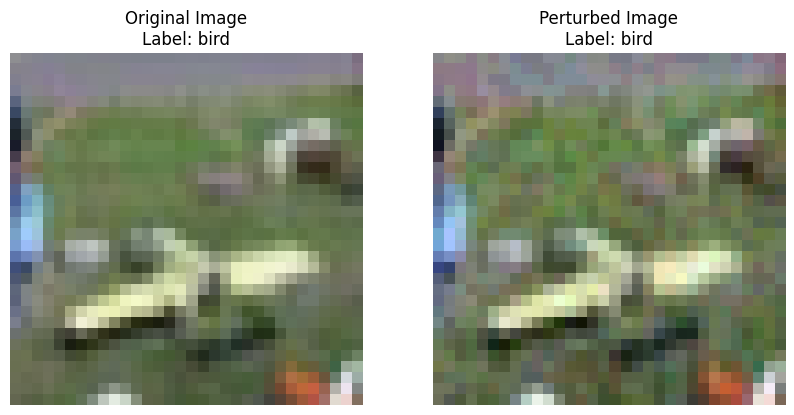

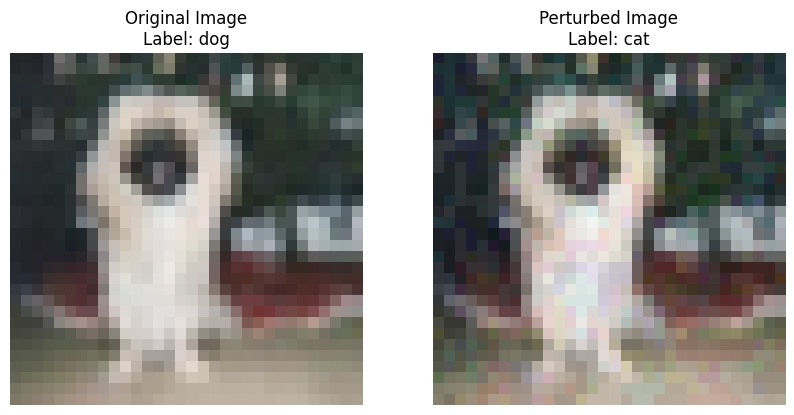

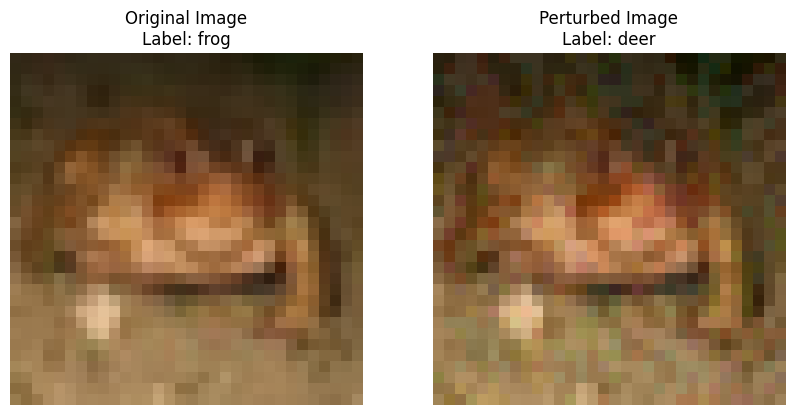

In [ ]:
##############################################################################
# Choose 3 random images from testset and run FGSM attack and visualize      #
##############################################################################
def visualize_fgsm_attack(model, testset, epsilon, num_images=3):
    model.eval()
    indices = np.random.choice(len(testset), num_images, replace=False)

    for idx in indices:
        image, label = testset[idx]
        image = image.unsqueeze(0).to(device)
        label = torch.tensor([label]).to(device)

        # Perform FGSM attack
        attack = torchattacks.FGSM(model, eps=epsilon)
        perturbed_image = attack(image, label)

        # Get model predictions
        original_pred = model(image).argmax(1).item()
        perturbed_pred = model(perturbed_image).argmax(1).item()

        # Plot images
        plot_images(image.squeeze(), perturbed_image.squeeze(), original_pred, perturbed_pred, classes)

epsilon = 8/255
visualize_fgsm_attack(model, testset, epsilon)
################################ End #########################################

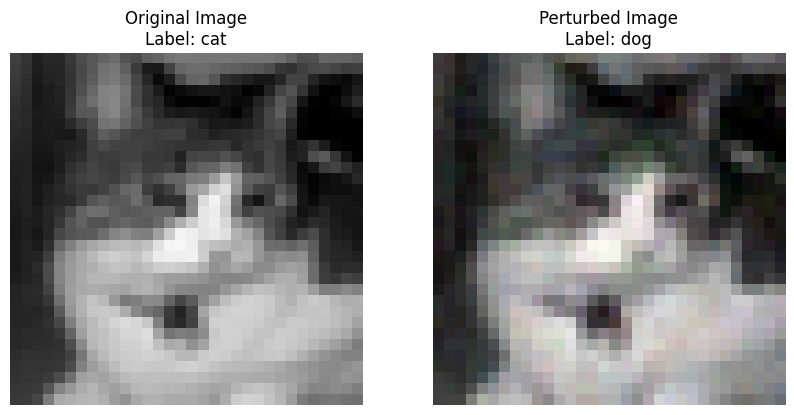

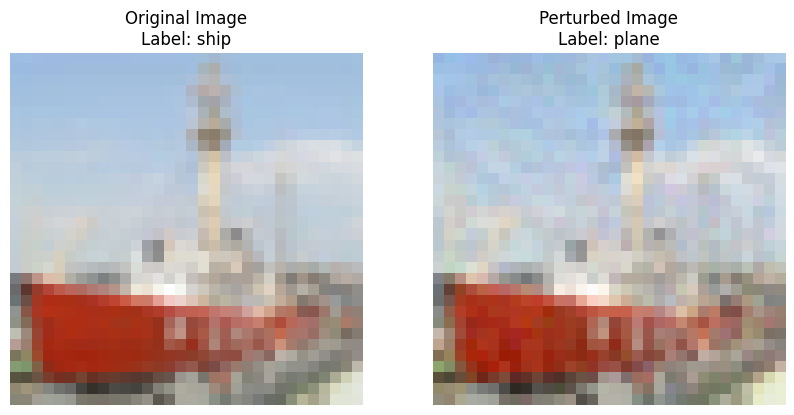

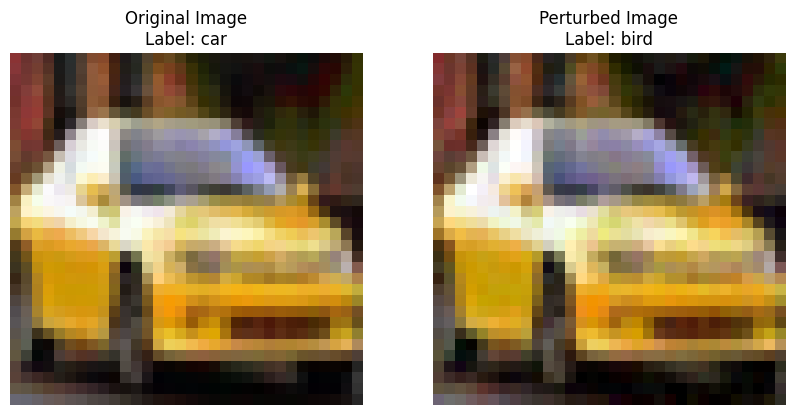

In [ ]:
##############################################################################
# Choose 3 random images from testset and run PGD attack and visualize      #
##############################################################################
def visualize_pgd_attack(model, testset, epsilon, k, alpha, num_images=3):
    model.eval()
    indices = np.random.choice(len(testset), num_images, replace=False)

    for idx in indices:
        image, label = testset[idx]
        image = image.unsqueeze(0).to(device)
        label = torch.tensor([label]).to(device)

        # Perform PGD attack
        pgd_attack = LinfPGDAttack(model, epsilon=epsilon, k=k, alpha=alpha)
        perturbed_image = pgd_attack(image, label)

        # Get model predictions
        original_pred = model(image).argmax(1).item()
        perturbed_pred = model(perturbed_image).argmax(1).item()

        # Plot images
        plot_images(image.squeeze(), perturbed_image.squeeze(), original_pred, perturbed_pred, classes)

epsilon = 8/255
alpha = 2/255
k = 4
visualize_pgd_attack(model, testset, epsilon, k, alpha)
################################ End #########################################

## Adversarial Training (35 pts)

In this section you are going to adversarially train your model and see the results.

In [ ]:
##############################################################################
# Load a new resnet model for adversarial training                           #
# Train the model on perturbed images from                                   #
# untargeted FGSM attack with epsilon = 8/255 on train dataset               #
# Also use the following setup for training the model                        #
##############################################################################

adv_model = resnet(num_cls=10).to(device)
adv_model.to(device)

learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(adv_model.parameters(), lr=learning_rate, momentum=0.9)
epochs = 100

epsilon = 8/255
fgsm_attack = torchattacks.FGSM(adv_model, eps=epsilon)

def adversarial_train(model, trainloader, criterion, optimizer, epochs):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            adv_inputs = fgsm_attack(inputs, labels)

            optimizer.zero_grad()

            outputs = model(adv_inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {running_loss / len(trainloader):.4f}')
    print('Finished Adversarial Training')

adversarial_train(adv_model, trainloader, criterion, optimizer, epochs)

################################ End #########################################

Epoch [1/100], Loss: 2.1324
Epoch [2/100], Loss: 2.0030
Epoch [3/100], Loss: 1.9389
Epoch [4/100], Loss: 1.8885
Epoch [5/100], Loss: 1.8500
Epoch [6/100], Loss: 1.8107
Epoch [7/100], Loss: 1.7739
Epoch [8/100], Loss: 1.7431
Epoch [9/100], Loss: 1.7147
Epoch [10/100], Loss: 1.6883
Epoch [11/100], Loss: 1.6441
Epoch [12/100], Loss: 1.6132
Epoch [13/100], Loss: 1.5777
Epoch [14/100], Loss: 1.5426
Epoch [15/100], Loss: 1.5035
Epoch [16/100], Loss: 1.4660
Epoch [17/100], Loss: 1.4289
Epoch [18/100], Loss: 1.3862
Epoch [19/100], Loss: 1.3454
Epoch [20/100], Loss: 1.3106
Epoch [21/100], Loss: 1.2663
Epoch [22/100], Loss: 1.2267
Epoch [23/100], Loss: 1.1905
Epoch [24/100], Loss: 1.1511
Epoch [25/100], Loss: 1.1104
Epoch [26/100], Loss: 1.0806
Epoch [27/100], Loss: 1.0435
Epoch [28/100], Loss: 1.0124
Epoch [29/100], Loss: 0.9739
Epoch [30/100], Loss: 0.9386
Epoch [31/100], Loss: 0.9109
Epoch [32/100], Loss: 0.8853
Epoch [33/100], Loss: 0.8617
Epoch [34/100], Loss: 0.8293
Epoch [35/100], Loss: 0

In [ ]:
##############################################################################
# Evaluate the new model on the test dataset                                 #
##############################################################################

def test_adversarial_model(model, testloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy of the adversarially trained model on the 10000 test images: {100 * correct / total:.2f}%')

# Test the adversarially trained model
test_adversarial_model(adv_model, testloader)

################################ End #########################################

Accuracy of the adversarially trained model on the 10000 test images: 60.99%


In [ ]:
##############################################################################
# Run FGSM attack on the adversarially trained model with epsilon = 8/255    #
##############################################################################

accuracy_fgsm = run_fgsm_attack(adv_model, testloader, epsilon)

################################ End #########################################

Accuracy of the model on the test images with FGSM attack (epsilon=0.03137254901960784): 22.97%


In [ ]:
##############################################################################
#  Run PGD attack on the adversarially trained model with k=4                #
##############################################################################

k = 4
alpha = 2/255
accuracy_pgd = run_pgd_attack(adv_model, testloader, epsilon, k, alpha)

################################ End #########################################

Accuracy of the model on the test images with PGD attack (epsilon=0.03137254901960784, k=4, alpha=0.00784313725490196): 19.02%


Answer the following questions:
- What happened to the accuracy of the adversarially trained model?

دقت مدل در این حالت کمتر از دقت مدل در حالتی که به صورت خصمانه آموزش ندیده بود شد که خب علتش هم همان نویزی بود که برای آموزش حالت خصمانه به آن اضافه میکردیم در قسمت آموزش

- What do you conclude from the result of the FGSM attack on the adversarially trained model?

در این حالت چون اینبار مدل را با اف جی اس ام به صورت خصمانه آموزش داده ایم و روی که اف جی اس ام به مدل اتک میزند را به مدل آموزش داده ایم سبب میشود که مدل ما کمتر درصد دقتش افت کند که به خاطر همین میتوان گفت موفقیت آمیز بوده است

- What do you conclude from the result of the PGD attack on the adversarially trained model?

در این حالت همانطور که میبینیم دقت از اتک قبلی همچنان پایین تر است دقت ما از اتک با پی جی دی به مدل بدون آموزش خصمانه بسیار بهتر است. به عبارتی با اینکه برای آموزش از اتک پی جی دی استفاده نمیکردیم ولی به هرحال نسبت به آن باز هم روباست تر شده است.

- What is you final conclusion?

متوجه میشویم که فارغ از اینکه مدل خود را به چه شکلی به صورت خصمانه آموزش بدهیم، نسبت به اکثر دیگر حمله ها نیز روباست تر خواهد بود نسبت به مدلی که به صورت ساده و بدون حالت خصمانه آموزش دیده است. البته این روباستنس را در ازای این داریم که دقت اصلی مدل در حالت عادی مقداری پایین تر خواهد آمد که احتمالا برای ما میصرفد.